# Import
First we import the necessary libraries and define functions

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from gudhi import RipsComplex
from gudhi import AlphaComplex
from gudhi.representations import Entropy
from gudhi.representations import DiagramSelector
import gudhi as gd
import plotly.graph_objects as go
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
import math


def calculaDiagramaPersistencia(puntos,dimension):
    rips_complex = AlphaComplex(points=puntos) # 0pcion 1
    simplex_tree = rips_complex.create_simplex_tree(max_alpha_square=maxd)
    # rips_complex = RipsComplex(points=nube_puntos,max_edge_length=maxd) # Option 2
    # simplex_tree = rips_complex.create_simplex_tree()
    diagrama_persistente = simplex_tree.persistence()
    persistence = simplex_tree.persistence_intervals_in_dimension(dimension)
    return persistence

def limitaDiagrama(Diagrama,maximaFiltracion):
    infinity_mask = np.isinf(Diagrama)
    Diagrama[infinity_mask] = maximaFiltracion 
    return Diagrama

def calculaEntropia(persistentBarcode):
    l=[]
    for i in persistentBarcode:
        l.append(i[1]-i[0])
    L = sum(l)
    p=l/L
    entropia=-np.sum(p*np.log(p))
    return round(entropia,4)

def dibujaNubePuntosInstante(time,robotVision=None):
    instante = ps[time]
    x=instante[:,0]
    y=instante[:,1]
    angle=instante[:,2]

    plt.figure(figsize=(4, 4))

    plt.quiver(x, y, np.cos(angle), np.sin(angle), color="blue",
            angles='xy', scale_units='xy', scale=5,width=0.01, headwidth=3, headlength=5,label=f"Initial time: {time}")
    
    if robotVision is not None:
        vision_radius = 3 
        field_of_view = np.pi / 2 #90 grades vision angle 
        xrobot=x[robotVision]
        yrobot=y[robotVision]
        orientation=angle[robotVision]
        arc_points = [[xrobot, yrobot]]  
        
        num_points = 50  
        for i in range(num_points + 1):
            angulos = orientation + field_of_view / 2 - (i / num_points) * field_of_view
            arc_points.append([xrobot + vision_radius * np.cos(angulos), yrobot + vision_radius * np.sin(angulos)])
        arc_points.append([xrobot, yrobot])  
        arc_points = np.array(arc_points)
        plt.plot(arc_points[:, 0], arc_points[:, 1], 'b-', alpha=0.3) 
        plt.fill(arc_points[:, 0], arc_points[:, 1], color='blue', alpha=0.1)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Point cloud in time: {time}')
    
def dibujaNubePuntos2Instantes(time1,time2):

    instante1 = ps[time1]
    instante2 = ps[time2]
    x1=instante1[:,0]
    y1=instante1[:,1]
    angle1=instante1[:,2]

    x2=instante2[:,0]
    y2=instante2[:,1]
    angle2=instante2[:,2]

    maxX=max(max(x1),max(x2)) + 1
    maxY=max(max(y1),max(y2)) + 1
    minX=min(min(x1),min(x2)) - 1
    minY=min(min(y1),min(y2)) - 1

    plt.figure(figsize=(4, 4))
    
    plt.quiver(x1, y1, np.cos(angle1), np.sin(angle1), color="blue",
            angles='xy', scale_units='xy', scale=5,width=0.01, headwidth=3, headlength=5,label=f"Initial time: {time1}")

    plt.quiver(x2, y2, np.cos(angle2), np.sin(angle2), color="red",
            angles='xy', scale_units='xy', scale=5,width=0.01, headwidth=3, headlength=5,label=f"End time: {time2}")
    for i in range(n_robots):
        plt.plot([x1[i], x2[i]], [y1[i], y2[i]], color='gray', linestyle='--',linewidth=0.5,alpha=0.5)
    plt.xlim(minX, maxX)
    plt.ylim(minY, maxY)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title('Point cloud in two times')
    plt.show()

def dibujaPersisteceDiagram(time):
    nube_puntos=ps[time,:,:2]
    persistence = calculaDiagramaPersistencia(nube_puntos,0)
    gd.plot_persistence_diagram(persistence)
    plt.title(f"Persistent diagram for time {time}")

def dibujaPersisteceBarcode(time):
    nube_puntos=ps[time,:,:2]
    persistence = calculaDiagramaPersistencia(nube_puntos,0)
    persistenciaL=limitaDiagrama(persistence,maxd)
    entropia=calculaEntropia(persistenciaL)
    gd.plot_persistence_barcode(persistenciaL)
    plt.title(f"Persistent barcode for time {time}; Entropy: {entropia}")
    


def dibujaEntropyTimeSerie(entropy):
    plt.plot(entropy,marker='o')
    plt.xlabel('Time')
    plt.ylabel('Entropy')
    plt.title(f'Topological entropy time series of persistent diagram')
    plt.grid(True)
    plt.show()

def dibujaEntropyTimeSerieInteractive(entropy):
    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x=np.arange(0,100), 
            y=entropy,
            mode='lines+markers',
            marker=dict(size=8),
        )
    )

    fig.update_layout(
        autosize=False,
        width=800,
        height=800,
        xaxis_title='Time',
        yaxis_title='Entropy',
        title=f'Topological entropy time series of persistent diagram'
    )

    fig.show()

def calcula_robots_en_campo_vision(time, robot):
    robots_en_campo = []
    vision_radius = 3
    field_of_view = np.pi / 2
    instante = ps[time]
    x=instante[:,0]
    y=instante[:,1]
    angle=instante[:,2]
    # Obtener la posición del robot que queremo y su orientación
    xObjetivo = x[robot]
    yObjetivo = y[robot]
    angleObjetivo = angle[robot]
    # Calcular los límites del campo de visión del primer robot
    angulo_inicio = angleObjetivo - field_of_view / 2
    angulo_fin = angleObjetivo + field_of_view / 2
    # Iterar sobre cada robot
    for i in range(0, len(x)):  # Empezar desde el segundo robot
        if i == robot:
            continue
        robot_x, robot_y = x[i],y[i]
        # Calcular la distancia entre el primer robot y el robot actual
        distancia = np.sqrt((robot_x - xObjetivo)**2 + (robot_y - yObjetivo)**2)
        # Calcular el ángulo entre la orientación del primer robot y la posición del robot actual
        angulo_robot = np.arctan2(robot_y - yObjetivo, robot_x - xObjetivo)
        # Verificar si el robot está dentro del campo de visión del primer robot
        if distancia <= vision_radius and angulo_robot >= angulo_inicio and angulo_robot <= angulo_fin:
            robots_en_campo.append(i)
    print(f"Robots en el campo de visión del robot {robot}:", robots_en_campo)
    return robots_en_campo

def calcular_distancia(x1, y1, x2, y2):
    distancia = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distancia

# Load the data. 

It corresponds to 100 point clouds with a time step of 0.1 seconds between each and 30 robots. We have the location of each robot and his angle of view. This data has been extracted from an experiment run of Navground (the software developed by SUPSI in WP3). https://idsia-robotics.github.io/navground/_build/html/index.html

In [110]:
ps = np.load("Robots.npy")
print(ps.shape) # 100 point clound with 30 robots and 3 features(x position, y position, angle view)
instantes=ps.shape[0]
n_robots=ps.shape[1]

ds = [pairwise_distances(X).flatten() for X in ps[:,:,:2]]
maxd = np.max(np.concatenate(ds))
print(maxd)

(100, 30, 3)
10.84102


We need to get the topology right. The topology of the point clouds can be inferred from several filterings, so we will use a fast and sparse (2D) one. First, we need to get an idea of the maximum filtering value to use, which we will approximate with the largest pairwise distance of the point clouds.

In [111]:
ds = [pairwise_distances(X).flatten() for X in ps[:,:,:2]]
maxd = np.max(np.concatenate(ds))
print(maxd)

10.84102


Now we can calculate the topological entropy of dimension 0 for each point cloud, for this we first calculate the persistence diagram, limit the bars that go to infinity and calculate the entropy. Finally we can plot the time series of the topology of how robots are located in each time and how they are moving.

Keep in mind that the first instant will have a very large entropy, or one of the largest, since by default Navground gives them very dispersed at the beginning of the experiment.

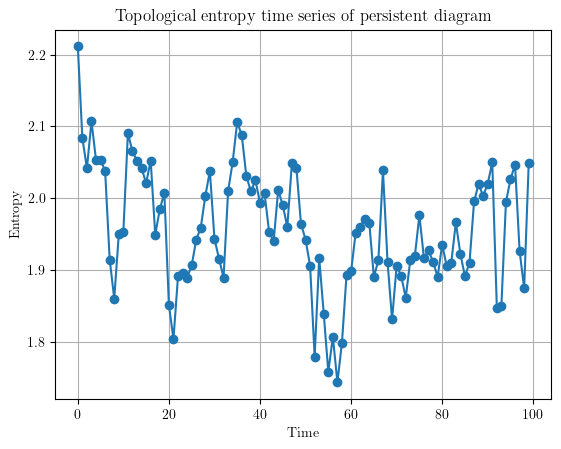

In [112]:
from gudhi.representations import DiagramSelector
entropias=[]
import gudhi as gd
for i in range(instantes):
    nube_puntos=ps[i,:,:2]
    persistence = calculaDiagramaPersistencia(nube_puntos,0)
    persistenciaL=limitaDiagrama(persistence,maxd)
    entropias.append(calculaEntropia(persistenciaL))
    
dibujaEntropyTimeSerie(entropias)
dibujaEntropyTimeSerieInteractive(entropias)

It would be interesting to know what it means to have a peak of high/low entropy(for example, the time with biggest entropy: 35; and with the lowest entropy: 57) in terms of this time series, as well as the meaning of little or much entropy differences between two consecutive time instants(for example times 92,93 and 94 marked in red.​

# We compare the time instants of highest and lowest topological entropy.

In [15]:
sorted_indices = np.argsort(entropias)
indices_menores = sorted_indices[:9]
indices_mayores = sorted_indices[-9:]

Point clouds with lower entropy

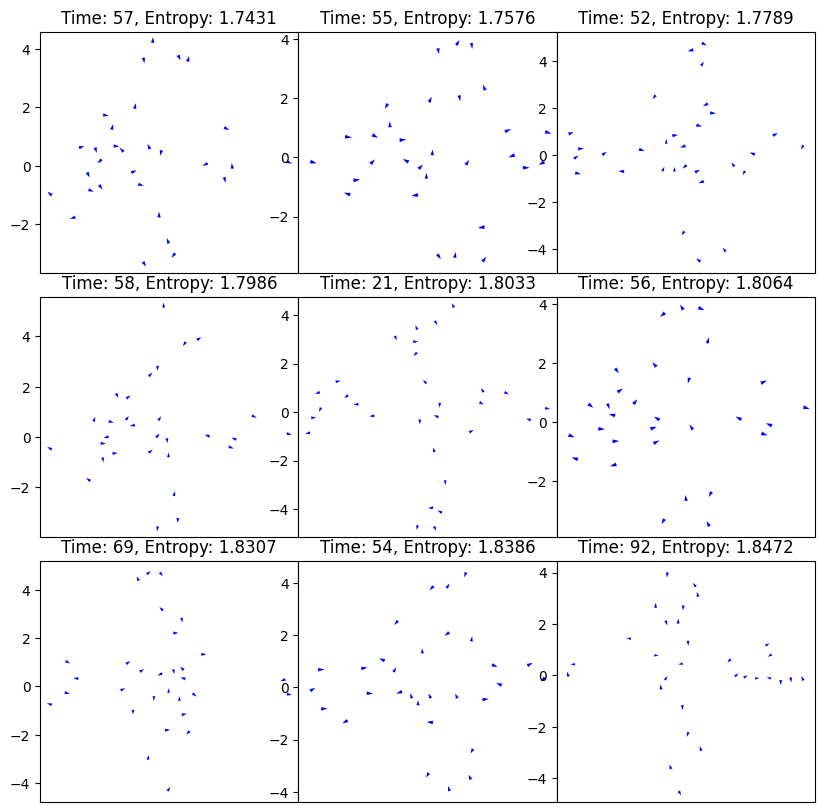

In [16]:
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.1)
for i in range(3):
    for j in range(3):
        instante = indices_menores[3*i+j]
        ax = plt.subplot(gs[i,j])
        ax.quiver(ps[instante][:,0], ps[instante][:,1], np.cos(ps[instante][:,2]), np.sin(ps[instante][:,2]), color="blue",
            angles='xy', scale_units='xy', scale=5,width=0.01, headwidth=3, headlength=5)
        plt.title(f"Time: {instante}, Entropy: {entropias[instante]}")
        plt.xticks([])
plt.show()

Point clouds with bigger entropy

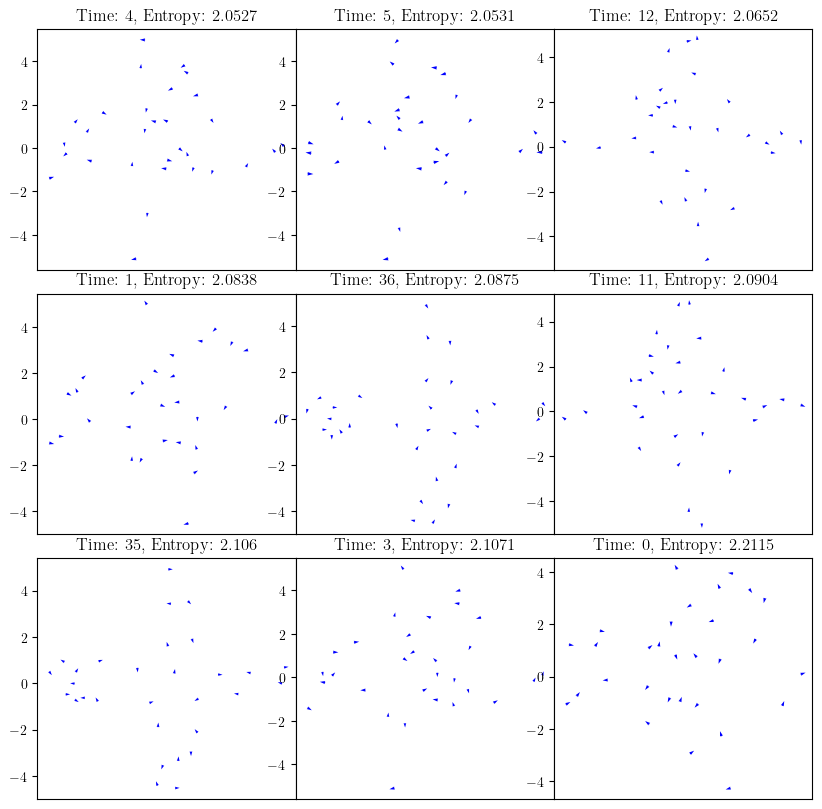

In [20]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.1)
for i in range(3):
    for j in range(3):
        instante = indices_mayores[3*i+j]
        ax = plt.subplot(gs[i,j])
        ax.quiver(ps[instante][:,0], ps[instante][:,1], np.cos(ps[instante][:,2]), np.sin(ps[instante][:,2]), color="blue",
            angles='xy', scale_units='xy', scale=5,width=0.01, headwidth=3, headlength=5)
        plt.title(f"Time: {instante}, Entropy: {entropias[instante]}")
        plt.xticks([])
plt.show()

Visualizing the persistent barcode

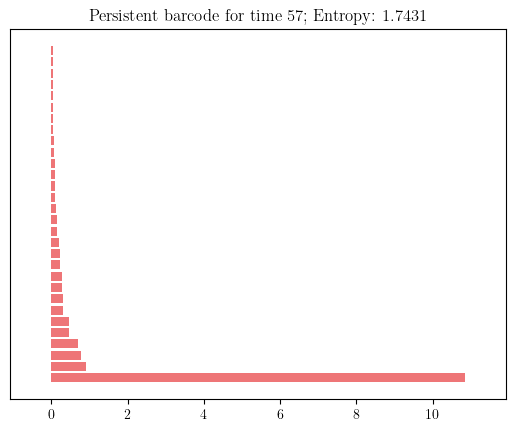

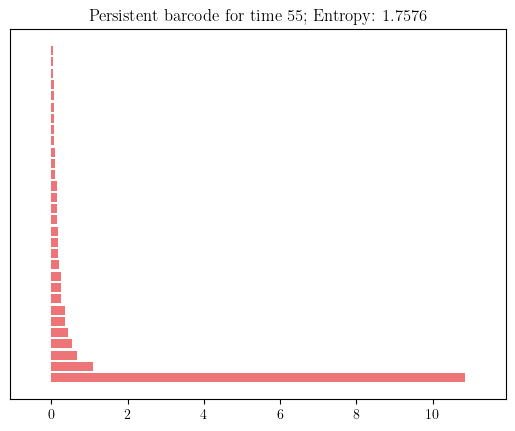

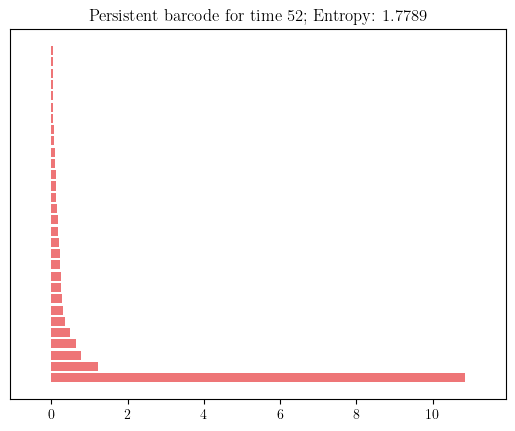

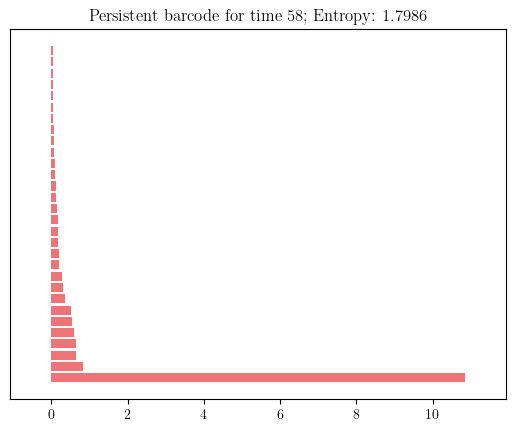

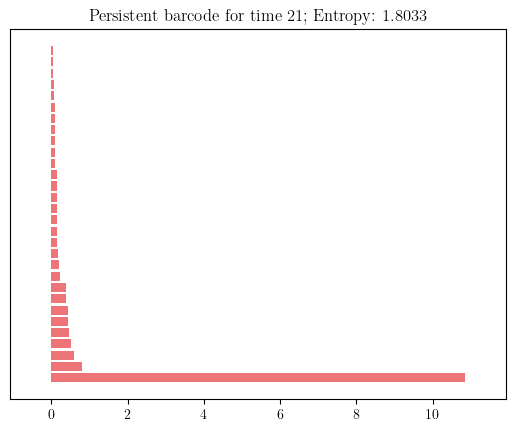

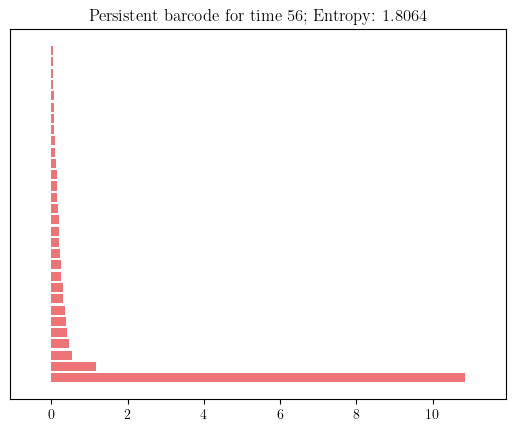

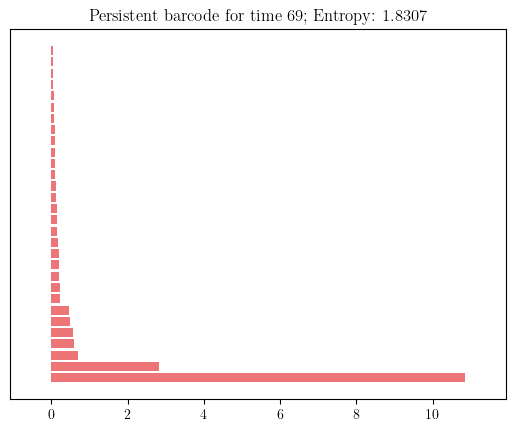

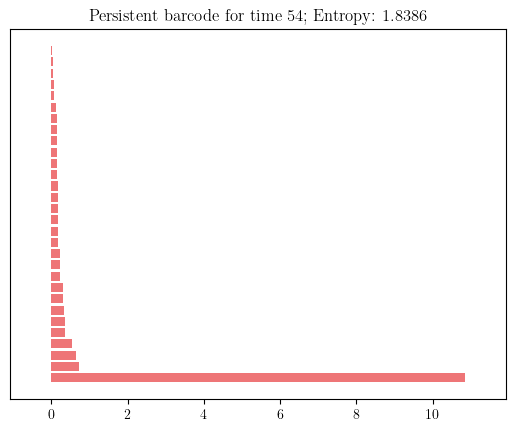

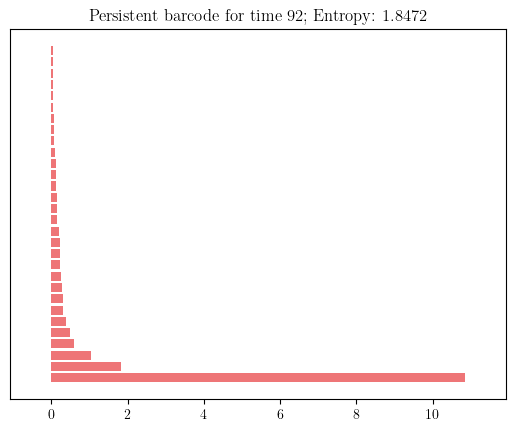

In [30]:
for i in range(9):
    dibujaPersisteceBarcode(indices_menores[i])

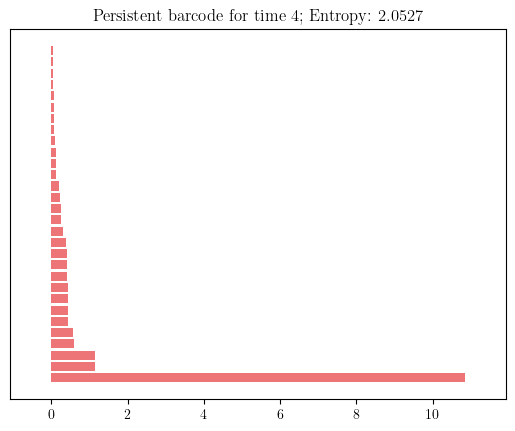

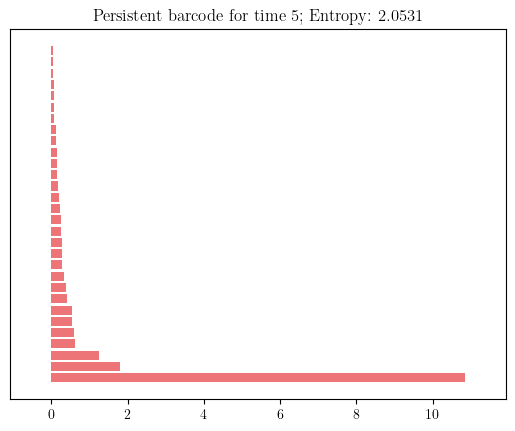

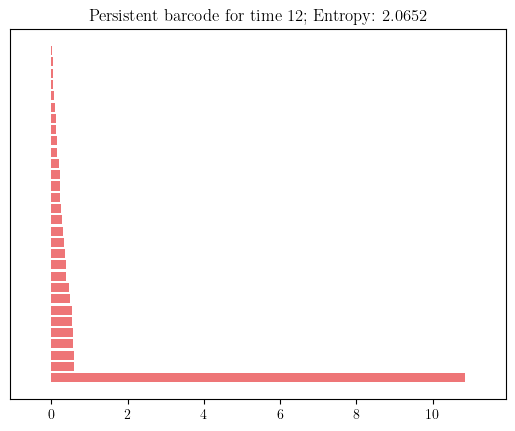

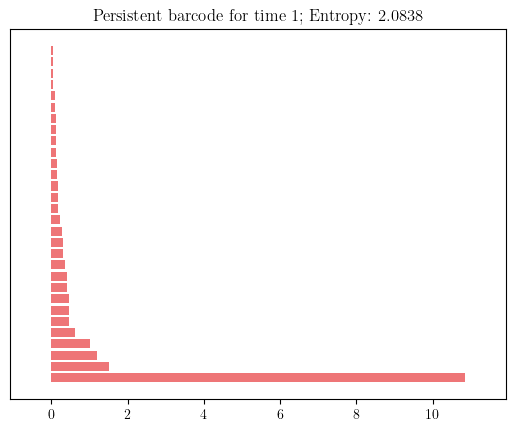

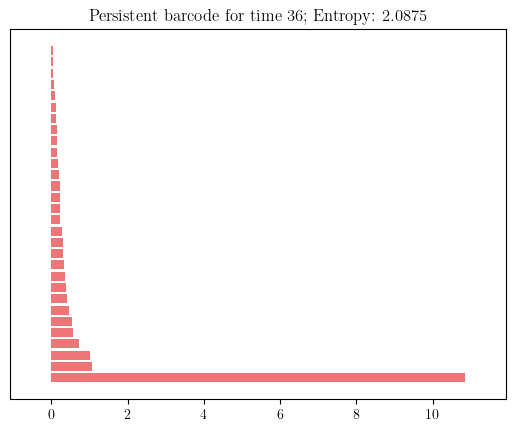

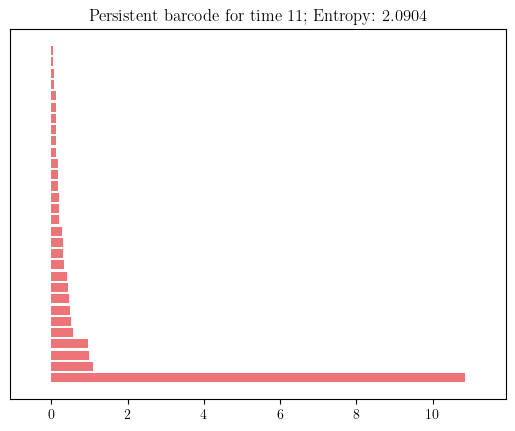

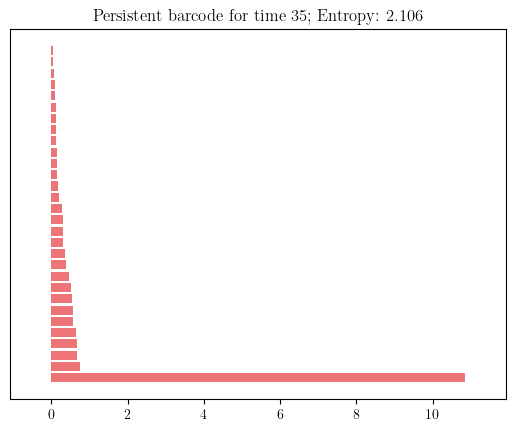

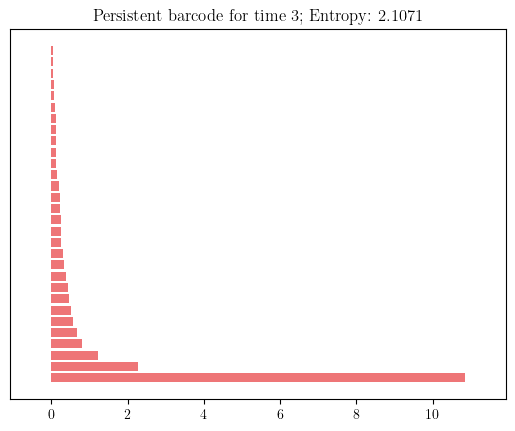

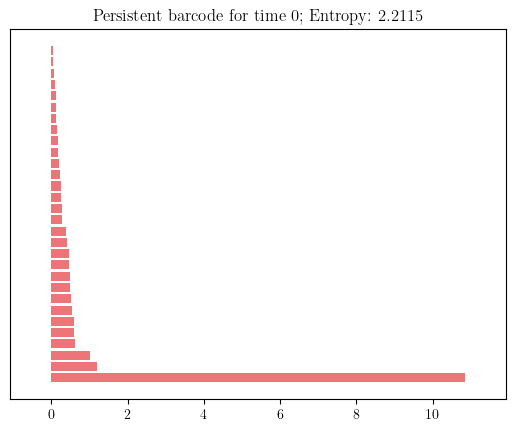

In [31]:
for i in range(9):
    dibujaPersisteceBarcode(indices_mayores[i])

We can say that: 

- Higher entropy:
    - Intervals in the persistence barcode are more evenly distributed in length
    - Suggests greater dispersion among the robots
- Lower entropy:
    - Intervals in the persistence barcode are more uneven distributed
    - Suggests that some robots form a group

# Comparing entropy difference between two consecutive time periods

Comparing times with very slight entropy change (92 and 93):

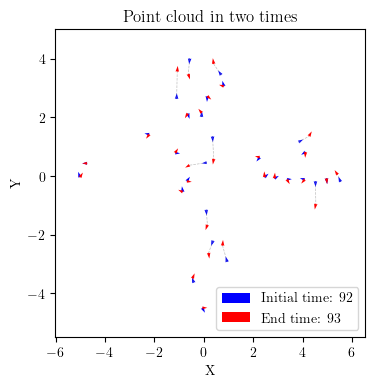

La distancia total que se han movido entre los instantes 92 y 93 es de 6.768355546360815 con una media por robot de: 0.22561185154536054 y con una mediana por robot de: 0.000304014418036978


In [52]:
time1=92
time2=93
dibujaNubePuntos2Instantes(time1,time2)
distancias=[]
for i in range(30):
    x1=ps[time1,i,0]
    y1=ps[time1,i,1]
    x2=ps[time2,i,0]
    y2=ps[time2,i,1]
    distancia=calcular_distancia(x1,y1,x2,y2)
    distancias.append(distancia)
print(f"La distancia total que se han movido entre los instantes {time1} y {time2} es de {sum(distancias)} con una media por robot de: {np.mean(distancias)} y con una mediana por robot de: {np.median(distancias)}")

Comparing times with larger entropy change (93 and 94):

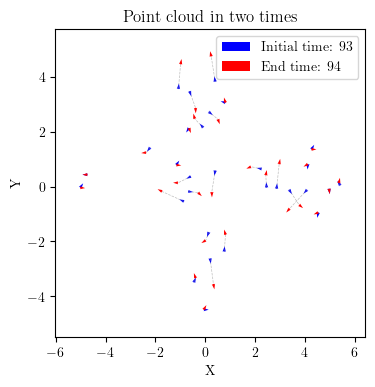

La distancia total que se han movido entre los instantes 93 y 94 es de 11.99650175703991 con una media por robot de: 0.39988339190133027 y con una mean por robot de: 0.39988339190133027


In [53]:
time1=93
time2=94
dibujaNubePuntos2Instantes(time1,time2)
distancias=[]
for i in range(30):
    x1=ps[time1,i,0]
    y1=ps[time1,i,1]
    x2=ps[time2,i,0]
    y2=ps[time2,i,1]
    distancia=calcular_distancia(x1,y1,x2,y2)
    distancias.append(distancia)
print(f"La distancia total que se han movido entre los instantes {time1} y {time2} es de {sum(distancias)} con una media por robot de: {np.mean(distancias)} y con una mean por robot de: {np.mean(distancias)}")

Another example: Low difference in entropy between times 9 and 10 and bigger difference between times 10 and 11

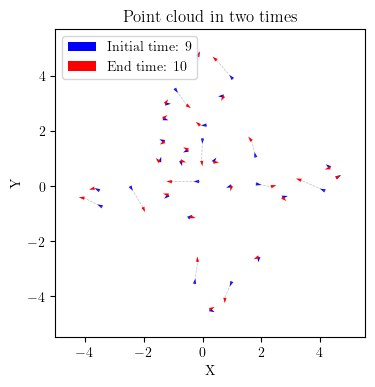

La distancia total que se han movido entre los instantes 9 y 10 es de 8.87937363778074 con una media por robot de: 0.29597912125935794 y con una mediana por robot de: 0.0047186551755621035


In [54]:
time1=9
time2=10
dibujaNubePuntos2Instantes(time1,time2)
distancias=[]
for i in range(30):
    x1=ps[time1,i,0]
    y1=ps[time1,i,1]
    x2=ps[time2,i,0]
    y2=ps[time2,i,1]
    distancia=calcular_distancia(x1,y1,x2,y2)
    distancias.append(distancia)
print(f"La distancia total que se han movido entre los instantes {time1} y {time2} es de {sum(distancias)} con una media por robot de: {np.mean(distancias)} y con una mediana por robot de: {np.median(distancias)}")

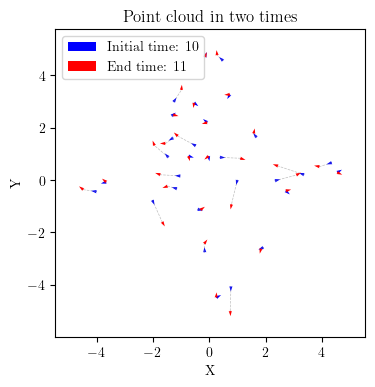

La distancia total que se han movido entre los instantes 10 y 11 es de 10.659376062172061 con una media por robot de: 0.3553125354057354 y con una mediana por robot de: 0.311150748799145


In [55]:
time1=10
time2=11
dibujaNubePuntos2Instantes(time1,time2)
distancias=[]
for i in range(30):
    x1=ps[time1,i,0]
    y1=ps[time1,i,1]
    x2=ps[time2,i,0]
    y2=ps[time2,i,1]
    distancia=calcular_distancia(x1,y1,x2,y2)
    distancias.append(distancia)
print(f"La distancia total que se han movido entre los instantes {time1} y {time2} es de {sum(distancias)} con una media por robot de: {np.mean(distancias)} y con una mediana por robot de: {np.median(distancias)}")

- Comparing times with very slight entropy 
    - Little to no movement of the robots
    - Suggests minimal change in position
- Comparing times with larger entropy change
    -  Significant movement and position change of the robots
    - Indicates a sharp change in entropy
- Conclusion:
    - Greater difference in entropy between two instants implies more movement and position change of the robots. It may be that the entropy has remained low, since only a few robots move a lot and others not at all, or because they do not move at all. Therefore a low entropy change between two points means that either there has generally been little change, or specific robots have moved somewhat more and the others not at all.

And if we calculate the topological entropy for the position of each time of each robots. Can it tell us information about his behavior

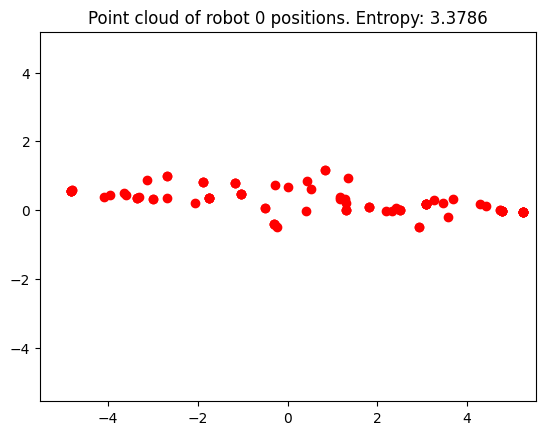

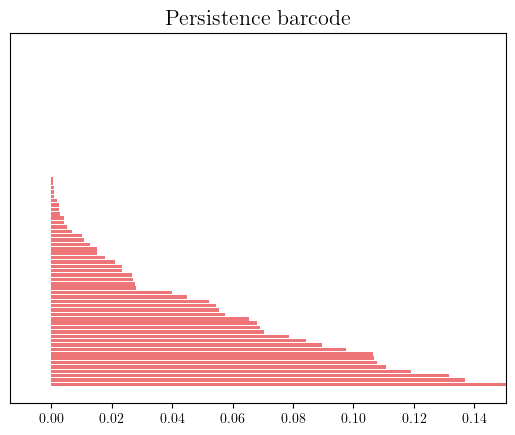

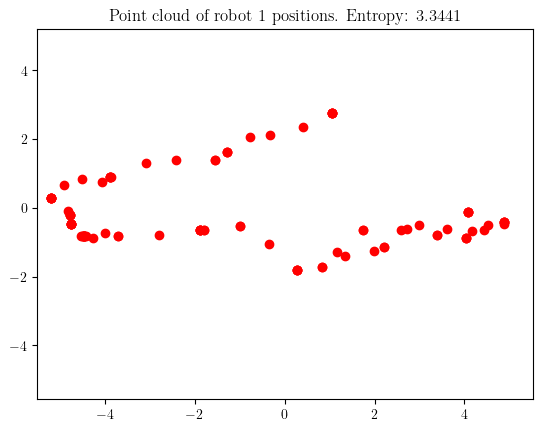

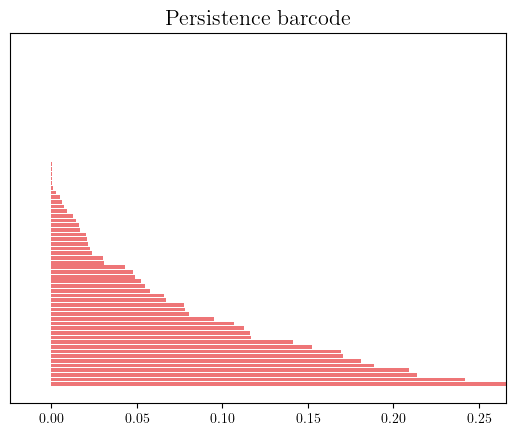

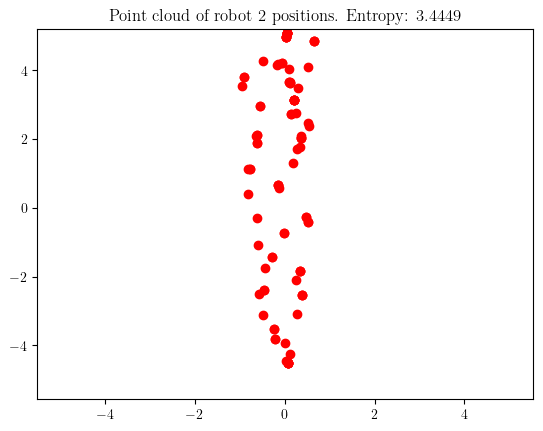

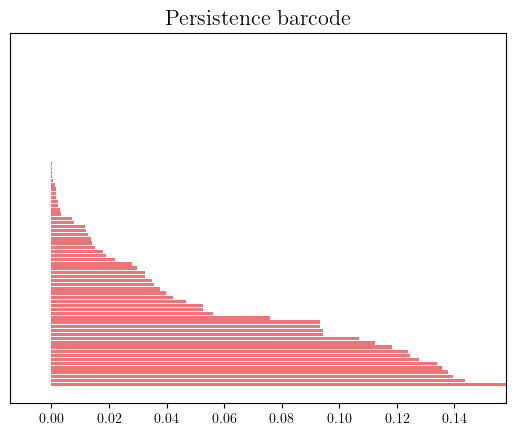

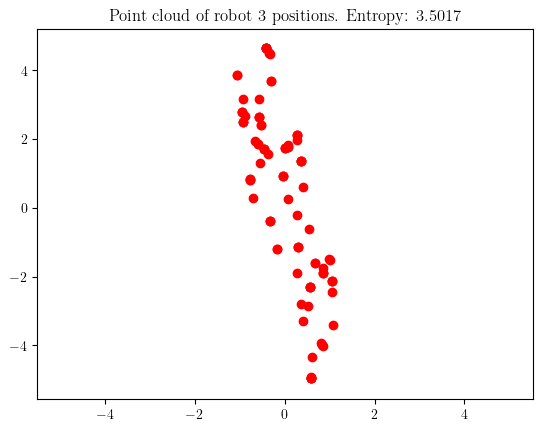

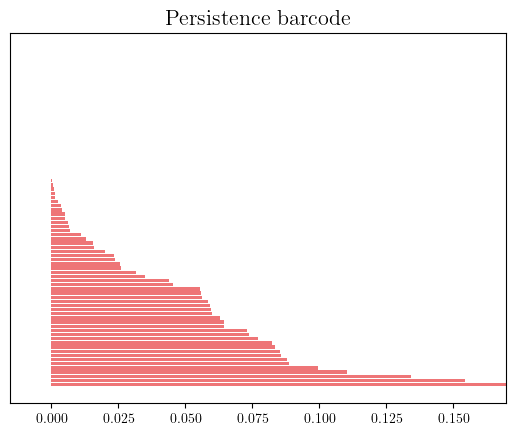

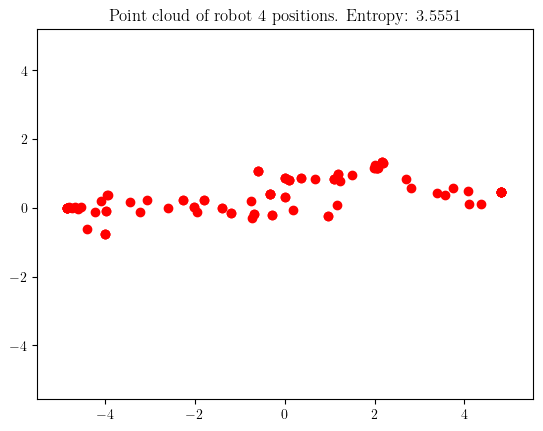

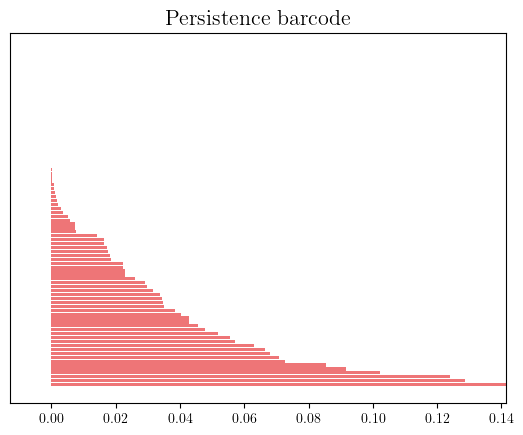

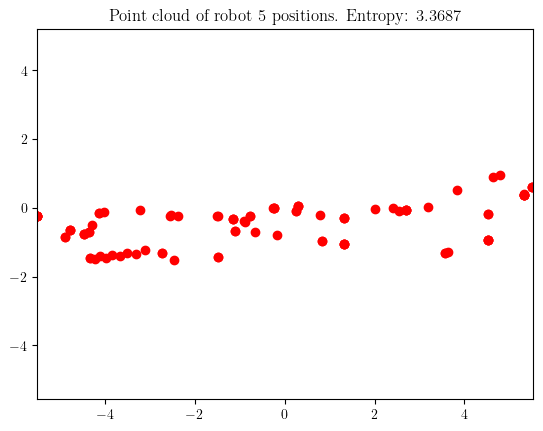

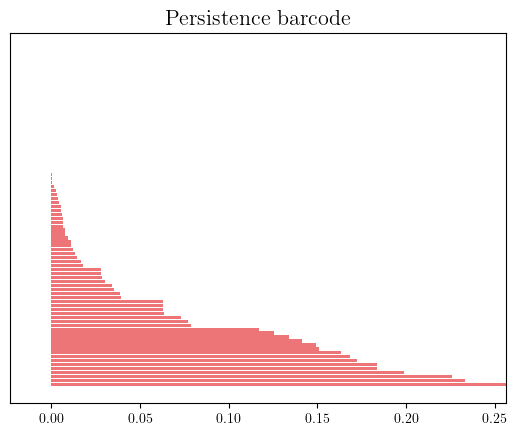

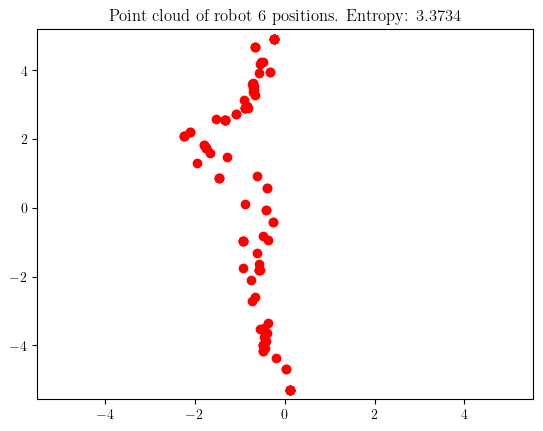

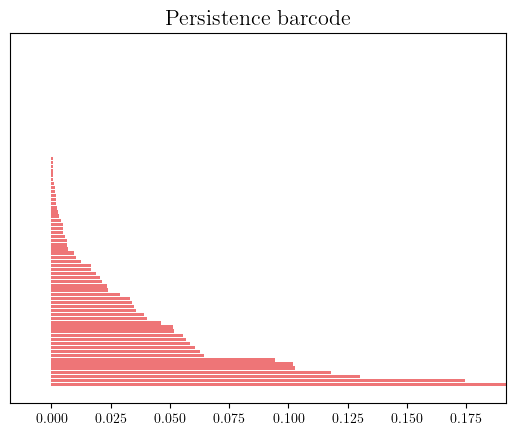

In [78]:
for i in [0,1,2,3,4,5,6]:
    robot=i
    minx=np.min(ps[:,:,0])
    maxx=np.max(ps[:,:,0])
    miny=np.min(ps[:,:,1])
    maxy=np.max(ps[:,:,1])
    puntos=ps[:,robot,:2]
    x=calculaDiagramaPersistencia(puntos,0)
    xL = DiagramSelector(use=True).fit_transform([x]) 
    entropia = calculaEntropia(xL[0])
    for z in range(100):
        plt.scatter(ps[z,robot,0],ps[z,robot,1],color="r")
    plt.xlim(minx,maxx)
    plt.ylim(miny,maxy)
    plt.title(f"Point cloud of robot {i} positions. Entropy: {entropia}")
    plt.show()
    gd.plot_persistence_barcode(x)
    plt.show()

Lower entropy appears to indicate a more uneven distribution in the length of intervals, suggesting that sometimes it has moved little and other times more, possibly indicating moments of deadlock and other more normal moments. On the other hand, higher entropy seems to indicate more consistent and more uniform distributed movement over time.

All this has been used to explain the situation of robots at a given instant of time and its relation to entropy, but what if we calculate the persistent entropy of a robot only with those within its field of view, so that this is able to explain future movements. Let's look at an example where we calculate the robots that are within the field of view of a robot.

Robots en el campo de visión del robot 0: [5, 6, 11, 12]


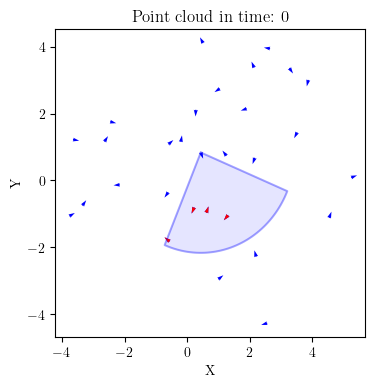

Persistent entropy: 1.0403


In [88]:
time=0
robot=0
instante = ps[time]
x=instante[:,0]
y=instante[:,1]
angle=instante[:,2]
dibujaNubePuntosInstante(time,robot)
robots=calcula_robots_en_campo_vision(time,robot)
plt.quiver(x[robots], y[robots], np.cos(angle[robots]), np.sin(angle[robots]), color="red",
        angles='xy', scale_units='xy', scale=5,width=0.01, headwidth=3, headlength=5)
plt.show()
robots.append(robot)
puntos=ps[0,robots,:2]
x=calculaDiagramaPersistencia(puntos,0)
xL = DiagramSelector(use=True).fit_transform([x]) 
entropia = calculaEntropia(xL[0])
print(f"Persistent entropy: {entropia}")


Robots en el campo de visión del robot 8: [20, 27]


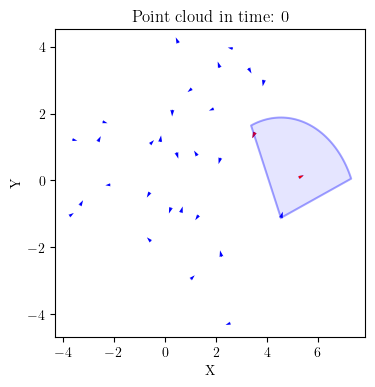

Persistent entropy: 0.6009


In [103]:
time=0
robot=8
instante = ps[time]
x=instante[:,0]
y=instante[:,1]
angle=instante[:,2]
dibujaNubePuntosInstante(time,robot)
robots=calcula_robots_en_campo_vision(time,robot)
plt.quiver(x[robots], y[robots], np.cos(angle[robots]), np.sin(angle[robots]), color="red",
        angles='xy', scale_units='xy', scale=5,width=0.01, headwidth=3, headlength=5)
plt.show()
robots.append(robot)
puntos=ps[0,robots,:2]
x=calculaDiagramaPersistencia(puntos,0)
xL = DiagramSelector(use=True).fit_transform([x]) 
entropia = calculaEntropia(xL[0])
print(f"Persistent entropy: {entropia}")

Robots en el campo de visión del robot 3: [0, 4, 11, 22, 25, 29]


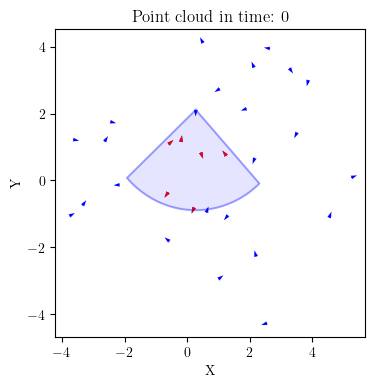

Persistent entropy: 1.5771


In [106]:
time=0
robot=3
instante = ps[time]
x=instante[:,0]
y=instante[:,1]
angle=instante[:,2]
dibujaNubePuntosInstante(time,robot)
robots=calcula_robots_en_campo_vision(time,robot)
plt.quiver(x[robots], y[robots], np.cos(angle[robots]), np.sin(angle[robots]), color="red",
        angles='xy', scale_units='xy', scale=5,width=0.01, headwidth=3, headlength=5)
plt.show()
robots.append(robot)
puntos=ps[0,robots,:2]
x=calculaDiagramaPersistencia(puntos,0)
xL = DiagramSelector(use=True).fit_transform([x]) 
entropia = calculaEntropia(xL[0])
print(f"Persistent entropy: {entropia}")

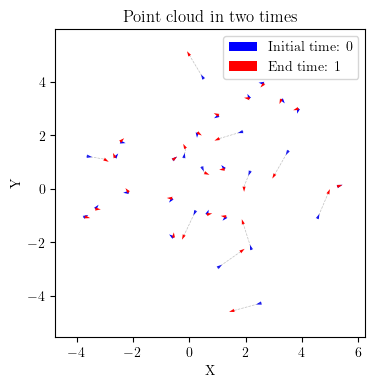

In [113]:
dibujaNubePuntos2Instantes(0,1)

We can observe how the more robots in the field of view there is a higher entropy, so a higher entropy for the field of view of a robot can mean greater difficulties to move. On the other hand, the lower the entropy the opposite, the clearer the path to where it is looking.

We can conclude for the moment from these results that robots with a lower entropy with respect to those in their field of view, move more between two consecutive time intervals.